# GTSRB Mask RCNN attempt

Documentation for a Mask R-CNN can be found [here](https://arxiv.org/abs/1703.06870). The work for this notebook followed this [tutorial](https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/).

The base layout was taken from the tutorial, as well as the base for the plot function at the end.

The github for Mask R-CNN is originally [here](https://github.com/matterport/Mask_RCNN/) and a fork of this from [here](https://github.com/ahmedfgad/Mask-RCNN-TF2) was used due to there being various version issues that needed to be handled to get it to work properly.

To see the classification capability of Mask RCNN, and potentially use the result as a base for the DTSDB dataset. The base parameters just use the COCO parameters which is the set commonly known for Mask RCNN. The results were less than ideal, and performance wasn't calculated due to how poorly it was performing. 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
import random

import tensorflow as tf
import glob
from sklearn import metrics
from tensorflow.keras import utils

from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from tensorflow.keras.models import load_model
from matplotlib import pyplot
from numpy import expand_dims
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

## Make information files

Making xml files for easier read in for the mask parsing. Could be other methods, I just have mine setup this way to make it easier to follow intial tutorial. Each folder has a CSV so the labels are loaded for each sign type and then the xml is made. 

In [3]:
#Train set
f_out =  open(f'dummy.xml','w')
prev_num = -1
for i in range(43):
    folder_num = str(i).rjust(5,'0')
    label_df = pd.read_csv(f'../GTSRB/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/{folder_num}/GT-{folder_num}.csv',delimiter = ';')
    for j in range(label_df.shape[0]):
        img_id = f'{folder_num}_{label_df.iloc[j,0][:-4]}'
        if prev_num != img_id:
            f_out.write("</annotation>")
            f_out.close()
            f_out = open(f'../GTSRB/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/xml/{img_id}.xml','w')
            f_out.write(f"""<annotation>
    <folder>{f'GTSRB/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/{folder_num}'}</folder>
    <path>{f'GTSRB/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/{folder_num}/{label_df.iloc[j,0]}'}</path>
    <source>
        <database>Unknown</database>
    </source>
    <filename>{label_df.iloc[j,0]}</filename>
    <size>
        <width>{label_df.iloc[j,1]}</width>
        <height>{label_df.iloc[j,2]}</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
""")
            f_out.write(f"""    <object>
        <name>{label_df.iloc[j,7]+1}</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{label_df.iloc[j,3]}</xmin>
            <ymin>{label_df.iloc[j,4]}</ymin>
            <xmax>{label_df.iloc[j,5]}</xmax>
            <ymax>{label_df.iloc[j,6]}</ymax>
        </bndbox>
    </object>
""")
            prev_num = img_id         
f_out.write("</annotation>")
f_out.close()


In [3]:
#Test Set
f_out =  open(f'dummy.xml','w')
prev_num = -1
folder_num = str(i).rjust(5,'0')
label_df = pd.read_csv(f'../GTSRB/GTSRB_Final_Test_GT/GT-final_test.csv',delimiter = ';')
for j in range(label_df.shape[0]):
    img_id = f'{label_df.iloc[j,0][:-4]}'
    if prev_num != img_id:
        f_out.write("</annotation>")
        f_out.close()
        f_out = open(f'../GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/xml/{img_id}.xml','w')
        f_out.write(f"""<annotation>
    <folder>{f'../GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/'}</folder>
    <path>{f'../GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/{label_df.iloc[j,0]}'}</path>
    <source>
        <database>Unknown</database>
    </source>
    <filename>{label_df.iloc[j,0]}</filename>
    <size>
        <width>{label_df.iloc[j,1]}</width>
        <height>{label_df.iloc[j,2]}</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
""")
        f_out.write(f"""    <object>
        <name>{label_df.iloc[j,7]+1}</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
            <xmin>{label_df.iloc[j,3]}</xmin>
            <ymin>{label_df.iloc[j,4]}</ymin>
            <xmax>{label_df.iloc[j,5]}</xmax>
            <ymax>{label_df.iloc[j,6]}</ymax>
        </bndbox>
    </object>
""")
        prev_num = img_id         
f_out.write("</annotation>")
f_out.close()


# Create dataset class

Create dataset class used for mask R-CNN, as well as configuration information

In [6]:
class SignDataset(Dataset):
    #Load the model
    #is_train loads the set type, dataset_dir is where images are
    #train_list and test_list to differntiate which file is what set
    def load_dataset(self, dataset_dir,is_train=True):
        #Two categories, normal and not
        for i in range(43):
            self.add_class('dataset',i+1,str(i+1))
        if is_train:
            files = glob.glob(dataset_dir + '*/*.ppm')
        else:
            files = glob.glob(dataset_dir + '*.ppm')
        for file in files:
            if is_train:
                image_id = f'{file[-21:-16]}_{file[-15:-4]}'
            else:
                image_id = f'{file[-9:-4]}'
            img_path = file
            ann_path = f'{dataset_dir}/xml/{image_id}.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, 
                       annotation=ann_path,class_ids=[0,1,2])
        
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//object'):
            name = box.find('name').text
            xmin = int(box.find('./bndbox/xmin').text)
            ymin = int(box.find('./bndbox/ymin').text)
            xmax = int(box.find('./bndbox/xmax').text)
            ymax = int(box.find('./bndbox/ymax').text)
            coors = [xmin, ymin, xmax, ymax, name]
            boxes.append(coors)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        # print(boxes)
        return boxes, width, height

    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = int(box[4])
            class_ids.append(self.class_names.index(str(box[4])))
        return masks, asarray(class_ids, dtype='int32')

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']


In [7]:
# define a configuration for the model
class SignConfig(Config):
	# define the name of the configuration
	NAME = "sign_cfg"
	# number of classes (background + normal + tumor)
	NUM_CLASSES = 1 + 43
	# number of training steps per epoch
	STEPS_PER_EPOCH = 131
 

In [8]:
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "sign_cfg"
    # number of classes (background + normal + tumor)
    NUM_CLASSES = 1 + 43
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.2
 

## Load training and test sets

In [9]:
train_set = SignDataset()
train_set.load_dataset('../GTSRB/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/',is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 39209


In [10]:
test_set = SignDataset()
test_set.load_dataset('../GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images/',is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))


Test: 12630


## Configure and Train model

In [12]:
# prepare config
config = SignConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                56
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [14]:
# define the model
model = MaskRCNN(mode='training', model_dir='../models', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=15, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./models\sign_cfg20210916T1403\mask_rcnn_sign_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistrib

# Make Predictions with final fit

Directory shown is last one used, update based off of the resulting directory from your fit performed above, which is auto generated when initialized. 

In [13]:
cfg = PredictionConfig()
model_inf = MaskRCNN(mode='inference', model_dir='../models/sign_cfg20210915T1732/', config=cfg)
# load model weights
model_path = '../models/sign_cfg20210915T1732/mask_rcnn_sign_cfg_0015.h5'
model_inf.load_weights(model_path, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead
Re-starting from epoch 15


Display code from the original Mask R-CNN repository with minor tweaks. This will recognize and draw predicted masks. 

In [14]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

image ID: dataset.03544 [3] (3544) ./GTSRB/GTSRB_Final_Test_Images/GTSRB/Final_Test/Images\03544.ppm
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  163.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   56.10000  float64
image_metas              shape: (1, 56)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[3 2] 3
gt_class_id              shape: (1,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (1, 4)                min:  170.00000  max:  853.00000  int32
gt_mask                  shape: (56, 56, 1)           min:    1.00000  max:    1.00000  bool


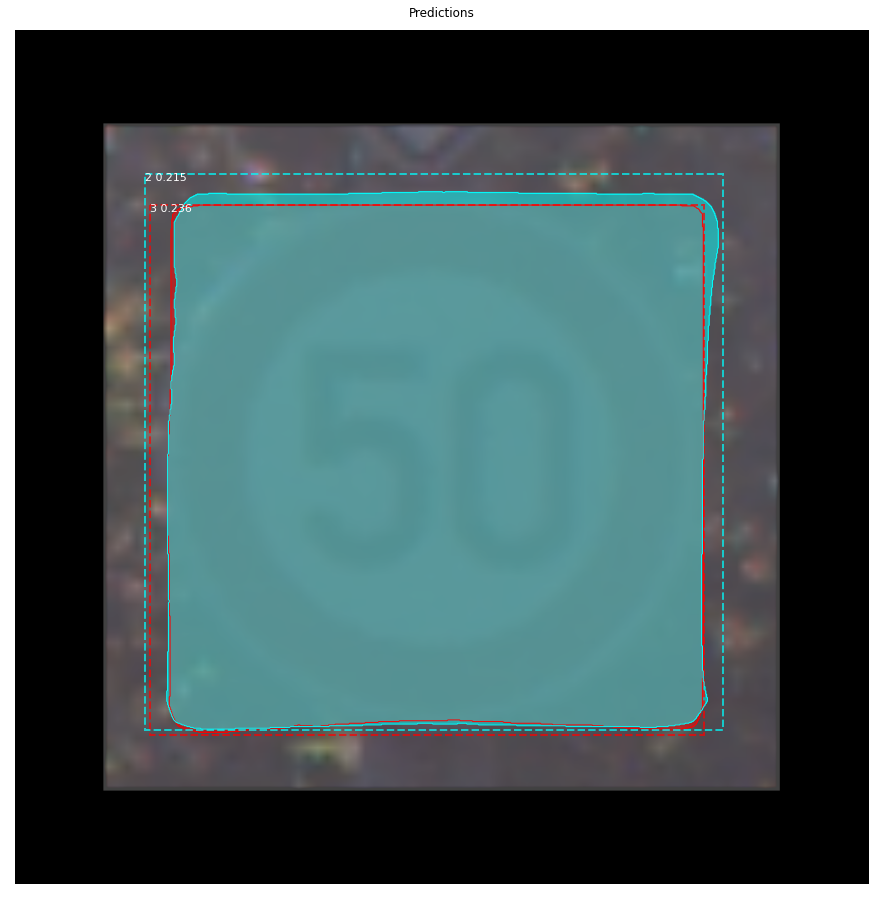

In [15]:
image_id = random.choice(test_set.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(test_set, config, image_id)
info = test_set.image_info[image_id]

print("image ID: {}.{} [{}] ({}) {}".format(info["source"], info["id"], label_df.iloc[image_id][7]+1,
                                            image_id, test_set.image_reference(image_id)))
results = model_inf.detect([image], verbose=1)

ax = get_ax(1)
r = results[0]
if len(r['class_ids'] > 0):
    print(r['class_ids'],label_df.iloc[image_id][7]+1)

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            test_set.class_names, r['scores'], ax=ax,
                            title="Predictions")

log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
